In [3]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import resnet50
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import TensorBoard

2022-12-11 15:58:29.725676: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-12-11 15:58:29.726649: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-12-11 15:58:29.726658: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [4]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow import keras
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
import cv2
from pathlib import Path
import pandas as pd
import time

### Paths

In [5]:
celeba_path = Path('../../../Dataset/img_celeba_cropped/')
celeba_identity_path = Path('../../Dataset/celeb_identity_processed.txt')

precalculated_triplets_path = Path('../../Dataset/triplets_27k.csv')

### Hyperparameters

In [316]:
triplets_count = 5000

train_size = 0.7

network_input_shape = (224, 224, 3)

batch_size = 32
lr = 1e-6

### a) Creating triplets

In [7]:
# df_identity = pd.read_csv(
#     celeba_identity_path,
#     sep=",",
#     names=["image", "identity"],
#     header=0,
#     dtype=str
# )

In [8]:
# def create_n_triplets(df_identity, n):
#     triplets = []

#     for triplet in range(n):
#         anchor_id = df_identity['identity'].sample(1, replace=True).to_string(index=False)

#         keepGoing = True
#         while (keepGoing):
#             anchor, positive = df_identity.loc[df_identity['identity'] == anchor_id]['image'].sample(2, replace=True)
#             keepGoing = (anchor == positive)

#         negative = df_identity.loc[df_identity['identity'] != anchor_id]['image'].sample(1, replace=True).to_string(index=False)

#         anchor = str(celeba_path) + '/' + anchor
#         positive = str(celeba_path) + '/' + positive
#         negative = str(celeba_path) + '/' + negative

#         triplets.append([anchor, positive, negative])

#     return pd.DataFrame(triplets, columns=['anchor', 'positive', 'negative'])

In [9]:
# triplets = create_n_triplets(df_identity, triplets_count)
# triplets.head()

,anchor,positive,negative
0,../../../Dataset/img_celeba_cropped/012914.jpg,../../../Dataset/img_celeba_cropped/108091.jpg,../../../Dataset/img_celeba_cropped/164323.jpg
1,../../../Dataset/img_celeba_cropped/124647.jpg,../../../Dataset/img_celeba_cropped/075814.jpg,../../../Dataset/img_celeba_cropped/150666.jpg
2,../../../Dataset/img_celeba_cropped/159123.jpg,../../../Dataset/img_celeba_cropped/092702.jpg,../../../Dataset/img_celeba_cropped/010869.jpg
3,../../../Dataset/img_celeba_cropped/129026.jpg,../../../Dataset/img_celeba_cropped/088511.jpg,../../../Dataset/img_celeba_cropped/029759.jpg
4,../../../Dataset/img_celeba_cropped/080037.jpg,../../../Dataset/img_celeba_cropped/077925.jpg,../../../Dataset/img_celeba_cropped/173277.jpg


### b) Loading triplet from csv

In [436]:
triplets = pd.read_csv(precalculated_triplets_path, sep=';')
triplets = str(celeba_path) + '/' + triplets

triplets.head()

,anchor,positive,negative
0,../../../Dataset/img_celeba_cropped/009642.jpg,../../../Dataset/img_celeba_cropped/051662.jpg,../../../Dataset/img_celeba_cropped/008648.jpg
1,../../../Dataset/img_celeba_cropped/192795.jpg,../../../Dataset/img_celeba_cropped/185091.jpg,../../../Dataset/img_celeba_cropped/198995.jpg
2,../../../Dataset/img_celeba_cropped/017332.jpg,../../../Dataset/img_celeba_cropped/141102.jpg,../../../Dataset/img_celeba_cropped/074735.jpg
3,../../../Dataset/img_celeba_cropped/115792.jpg,../../../Dataset/img_celeba_cropped/073536.jpg,../../../Dataset/img_celeba_cropped/067414.jpg
4,../../../Dataset/img_celeba_cropped/087777.jpg,../../../Dataset/img_celeba_cropped/020285.jpg,../../../Dataset/img_celeba_cropped/115354.jpg


In [437]:
triplets = triplets[:triplets_count]
triplets.shape

(5000, 3)

### Visualize triplets

In [438]:
def visualize_triplets(triplets):
    def show(ax, path):
        img = cv2.imread(path)

        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], triplets.iloc[i][0])
        show(axs[i, 1], triplets.iloc[i][1])
        show(axs[i, 2], triplets.iloc[i][2])

In [439]:
#visualize_triplets(triplets)

### TF Pipeline

In [440]:
def preprocessing(anchor, positive, negative):
    return (
        convert_to_img(anchor),
        convert_to_img(positive),
        convert_to_img(negative)
    )


def convert_to_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img)
    img = resnet50.preprocess_input(img)
    return img

In [441]:
features = tf.data.Dataset.from_tensor_slices((triplets['anchor'].values, triplets['positive'].values, triplets['negative'].values))
features = features.map(preprocessing)

fake_labels = tf.data.Dataset.from_tensor_slices(np.ones(triplets.shape[0]))


dataset = tf.data.Dataset.zip((features, fake_labels))

### Test val splits

In [442]:
train_dataset = dataset.take(round(triplets.shape[0] * train_size))
val_dataset = dataset.skip(round(triplets.shape[0] * train_size))

### Performance optimization

In [443]:
train_dataset = train_dataset \
        .batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE) \
        .prefetch(buffer_size=tf.data.AUTOTUNE) \
        .cache()

val_dataset = val_dataset \
        .batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE) \
        .prefetch(buffer_size=tf.data.AUTOTUNE) \
        .cache()

### Models

### Resnet 50

In [445]:
def resnet_embedding():
    input = layers.Input(shape=network_input_shape)

    base_cnn = resnet50.ResNet50(
        input_tensor=input,
        include_top=False,
        input_shape=network_input_shape,
        weights='imagenet'
    )

    for layer in base_cnn.layers[0:-3]:
        layer.trainable = False

    model = layers.Flatten()(base_cnn.output)

    #model = tf.keras.layers.Dropout(0.4)(model)
    #model = layers.Dense(512, activation="relu")(model)

    #model = tf.keras.layers.Dropout(0.4)(model)
    #model = layers.Dense(512, activation="relu")(model)

    #model = tf.keras.layers.Dropout(0.4)(model)
    #model = layers.Dense(512, activation="relu")(model)

    model = tf.keras.layers.Dropout(0.4)(model)
    model = layers.Dense(512, activation="relu")(model)

    model = layers.Dense(512)(model)

    return Model(input, outputs=model, name='resnet50')

### Convnet

In [446]:
def conv_embedding():
    input = layers.Input(shape=network_input_shape)
    x = layers.Flatten()(input)

    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(.2)(x)

    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(.2)(x)

    x = layers.Dense(248, activation='relu')(x)
    x = layers.Dropout(.2)(x)

    x = layers.Dense(248, activation='relu')(x)
    x = layers.Dropout(.2)(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)

    return Model(inputs=input, outputs=x, name='dense_net')

In [447]:
class TripletLoss(layers.Layer):

    def __init__(self, margin, **kwargs):
        self.margin = margin
        super().__init__(**kwargs)

    def euclidean_distance(self, x, y):
        sum_square = tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)
        return tf.sqrt(tf.maximum(sum_square, K.epsilon()))

    def call(self, anchor, positive, negative):
        positive_distance = self.euclidean_distance(anchor, positive)
        negative_distance = self.euclidean_distance(anchor, negative)

        loss = positive_distance - negative_distance

        return tf.maximum(loss + self.margin, 0.0)

In [448]:
def identity_loss(y_true, y_pred):
    return tf.reduce_mean(y_pred)

In [449]:
anchor_input = layers.Input(shape=network_input_shape, name='anchor_input')
positive_input = layers.Input(shape=network_input_shape, name='right_input')
negative_input = layers.Input(shape=network_input_shape, name='negative_input')

In [450]:
# embedding = convnet_embedding()
embedding = resnet_embedding()

distances = TripletLoss(margin=1)(
    embedding(anchor_input),
    embedding(positive_input),
    embedding(negative_input)
)

model = Model(
    inputs=[anchor_input, positive_input, negative_input],
    outputs=distances,
    name='resnet50',
)

In [451]:
def identity_loss(y_true, y_pred):
    return tf.reduce_mean(y_pred)

In [452]:
model.compile(
    optimizer=Adam(learning_rate=lr),
    loss=identity_loss,
)

In [453]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 anchor_input (InputLayer)      [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 right_input (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 negative_input (InputLayer)    [(None, 224, 224, 3  0           []                               
                                )]                                                         

In [454]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### a) Loading model

In [455]:
#model = keras.models.load_model(model_path)

### b) Training and saving a new model

### Callbacks

In [456]:
tensorboard = TensorBoard(
    log_dir=f"logs/{model.name}_{time.strftime('run_%Y_%m_%d-%H_%M_%S')}",
    histogram_freq=1,
    embeddings_freq=1,
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    verbose=1,
)

lr_scheduler_reduce = keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5)

In [457]:
callbacks_list = [
    early_stopping,
    lr_scheduler_reduce,
    #tensorboard,
]

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    callbacks=callbacks_list,
    epochs=10,
)

Epoch 1/10
 85/110 [======================>.......] - ETA: 7s - loss: 2.0569

### Save model

In [435]:
checkpoints_path = 'checkpoints'
model_version = f'{model.name}-{time.strftime("%Y%m%d-%H%M%S")}'

model_path = f'checkpoints/{model_version}'
model.save(model_path)

INFO:tensorflow:Assets written to: checkpoints/resnet50-20221211-185419/assets


INFO:tensorflow:Assets written to: checkpoints/resnet50-20221211-185419/assets


### Performance evaluation

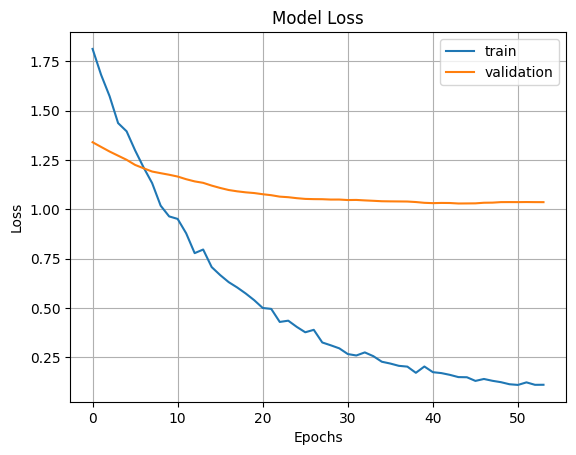

In [416]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.grid()

plt.show()

### Predictions

In [417]:
def create_balanced_pairs(df_identity, images):
    pairs = []

    for triplet in range(images):
        anchor_id = df_identity['identity'].sample(1, replace=True).to_string(index=False)

        positive_pair = df_identity.loc[df_identity['identity'] == anchor_id]['image'].sample(2, replace=True).to_list()
        negative = df_identity.loc[df_identity['identity'] != anchor_id]['image'].sample(1, replace=True).to_string(index=False)

        positive_pair[0] = str(celeba_path) + '/' + positive_pair[0]
        positive_pair[1] = str(celeba_path) + '/' + positive_pair[1]
        negative = str(celeba_path) + '/' + negative

        pairs.append([positive_pair[0], positive_pair[1], 1])
        pairs.append([positive_pair[0], negative, 0])

    return pd.DataFrame(pairs, columns=['left', 'right', 'label'])

In [418]:
pairs = create_balanced_pairs(df_identity, 500)

In [419]:
pairs.head(6)

,left,right,label
0,../../../Dataset/img_celeba_cropped/084132.jpg,../../../Dataset/img_celeba_cropped/078299.jpg,1
1,../../../Dataset/img_celeba_cropped/084132.jpg,../../../Dataset/img_celeba_cropped/143102.jpg,0
2,../../../Dataset/img_celeba_cropped/116342.jpg,../../../Dataset/img_celeba_cropped/016382.jpg,1
3,../../../Dataset/img_celeba_cropped/116342.jpg,../../../Dataset/img_celeba_cropped/183060.jpg,0
4,../../../Dataset/img_celeba_cropped/093320.jpg,../../../Dataset/img_celeba_cropped/011722.jpg,1
5,../../../Dataset/img_celeba_cropped/093320.jpg,../../../Dataset/img_celeba_cropped/001512.jpg,0


In [420]:
def visualize_pairs(pairs):
    def show(ax, path):
        img = cv2.imread(path)
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(5, 15))

    axs = fig.subplots(6, 2)
    for i in range(6):
        show(axs[i, 0], pairs.iloc[i][0])
        show(axs[i, 1], pairs.iloc[i][1])

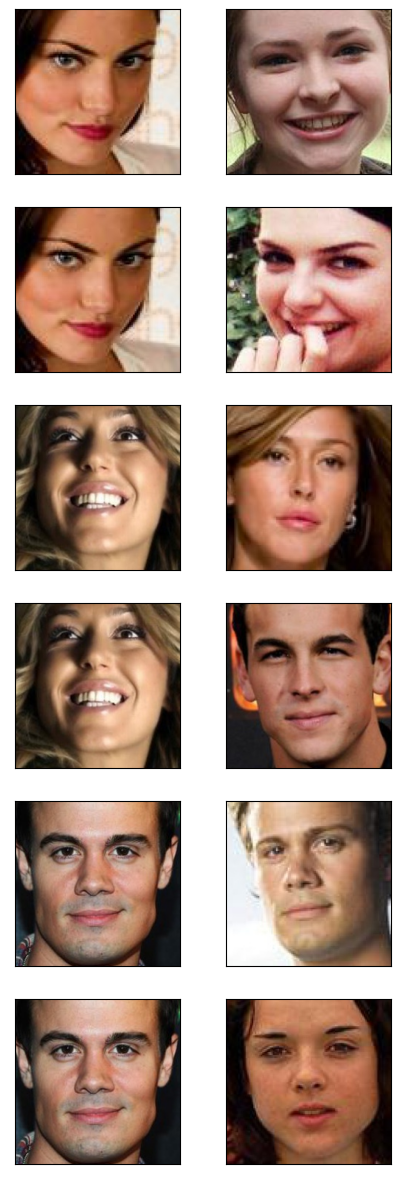

In [421]:
visualize_pairs(pairs)

In [422]:
def create_singular_dataset(feature):
    dataset = tf.data.Dataset.from_tensor_slices(feature.values)
    dataset = dataset.map(convert_to_img)
    dataset = dataset.batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

In [423]:
test_ds_left = create_singular_dataset(pairs['left'])
test_ds_right = create_singular_dataset(pairs['right'])
test_labels = pairs['label']

In [424]:
left_image_feature_vectors = embedding.predict(test_ds_left)
right_image_feature_vectors = embedding.predict(test_ds_right)

32/32 [==============================] - 3s 97ms/step


In [425]:
positive_left_image_feature_vectors = left_image_feature_vectors[0::2]
negative_left_image_feature_vectors = left_image_feature_vectors[1::2]

positive_right_image_feature_vectors = right_image_feature_vectors[0::2]
negative_right_image_feature_vectors = right_image_feature_vectors[1::2]

In [426]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.reduce_sum(tf.square(tf.subtract(x, y)), axis=1, keepdims=True)
    return tf.sqrt(tf.maximum(sum_square, K.epsilon()))

In [427]:
positive_distances = euclidean_distance((positive_left_image_feature_vectors, positive_right_image_feature_vectors)).numpy().flatten()
positive_mean = pd.Series(positive_distances).mean()
pd.Series(positive_distances).describe()

count    500.000000
mean      34.563858
std       10.128105
min        0.000316
25%       34.687897
50%       36.885143
75%       39.091754
max       49.437801
dtype: float64

In [428]:
negative_distances = euclidean_distance((negative_left_image_feature_vectors, negative_right_image_feature_vectors)).numpy().flatten()
negative_mean = pd.Series(negative_distances).mean()
pd.Series(negative_distances).describe()

count    500.000000
mean      39.395710
std        3.282479
min       30.014391
25%       37.079577
50%       39.436308
75%       41.307679
max       50.555359
dtype: float64

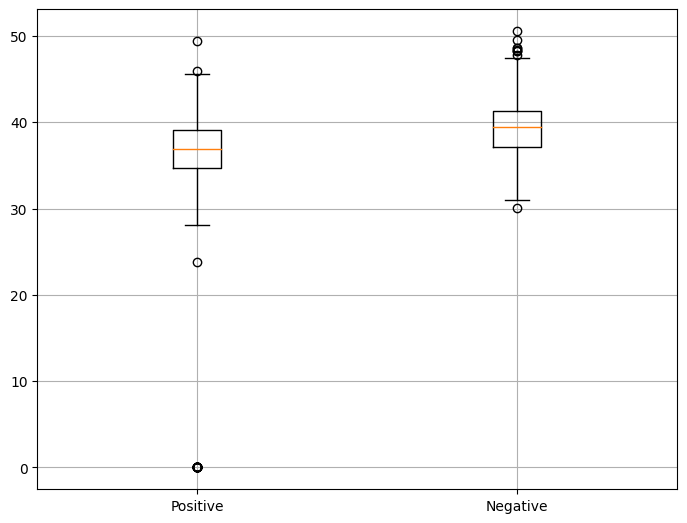

In [429]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.boxplot([positive_distances, negative_distances])
plt.xticks([1, 2], ['Positive', 'Negative'])
ax.grid()
plt.show()

In [430]:
def compute_accuracy(y_true, y_pred, cutoff):
    pred = y_pred.flatten() < cutoff
    return np.mean(pred == y_true), pred

In [431]:
y_pred = np.linalg.norm(left_image_feature_vectors-right_image_feature_vectors, axis=1)
cutoff = (positive_mean + negative_mean)/2

In [432]:
test_accuracy, y_pred = compute_accuracy(test_labels, y_pred, cutoff)
print(f'Accuracy: {test_accuracy*100:.2f}%')

Accuracy: 63.80%


<AxesSubplot: >

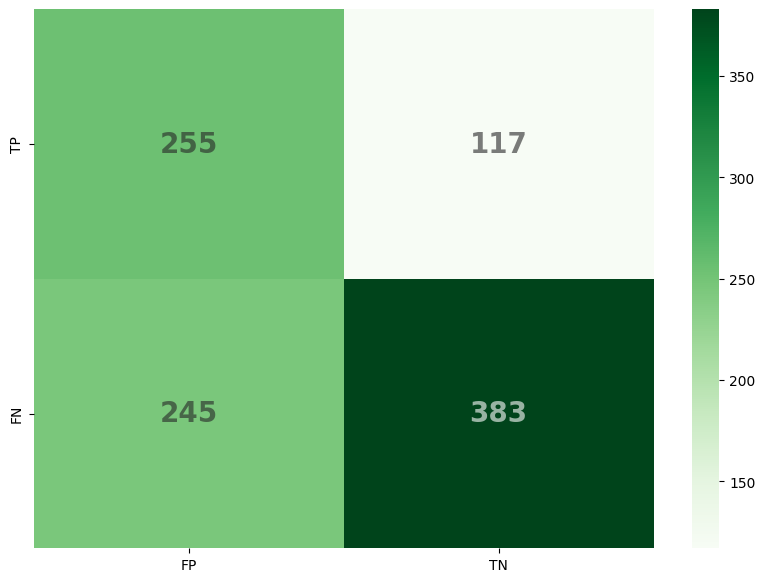

In [433]:
c_matrix = confusion_matrix(y_pred, test_labels, labels=[1, 0])
c_matrix_df = pd.DataFrame(c_matrix, index=["TP", "FN"], columns=["FP", "TN"])
plt.figure(figsize=(10, 7))
sn.heatmap(c_matrix_df, cmap="Greens", annot=True,
          annot_kws={'fontsize': 20, 'fontweight': 'bold', 'alpha': 0.6},
          fmt='g')

In [434]:
report = classification_report(y_pred, test_labels)
print(report)

              precision    recall  f1-score   support

       False       0.77      0.61      0.68       628
        True       0.51      0.69      0.58       372

    accuracy                           0.64      1000
   macro avg       0.64      0.65      0.63      1000
weighted avg       0.67      0.64      0.64      1000



### Observe FP and FN